In [1]:
import path
import libs.checker as checker
from control import *
from z3 import *

This example is borrowed and adapted from [1], which demonstrates a hybrid system design of a PD controller that drives a car position *p* to a desired position *r*, the design needs to satisfy a safety requirment: it never cross the desired position:
$$
\forall t . p(t) \le r
$$

The original design of the closed-loop function can be Laplace transformed into:
$$
H(s) = \frac{K_d s + K_p}{s^2+K_d s + K_p}
$$
where $K_p <= 2$ and $K_d > 0$ and $5 K_d < K_p$

We approximate it by a standard 2nd-order function:
$$
\hat{H}(s) = \frac{K_p}{s^2+K_d s + K_p}
$$

Using our symbolic static checking, the design is found that doesn't met the safety requirement. In this case, our checker return *sat* and a counter example.

[1] Jan-David Quesel, Stefan Mitsch, Sarah Loos, Nikos Aréchiga, and André Platzer. How to model and prove hybrid systems with KeYmaera: A tutorial on safety. STTT 18(1), pp. 67-91, 2016.

In [2]:
# Constants
Kp = Real('Kp')
Kd = Real('Kd')
r = Real('r')
zeta =  Real('zeta')
omega_n = Real('omega_n')

# Approximated Design
f1 = Kp == omega_n * omega_n
f2 = Kd == (2*omega_n*zeta)
f3 = zeta >= 0
f4 = Kp <= 2
f5 = omega_n > 0
f6 = Kd > 0
f7 = 5 * Kd < Kp
context = And(f1,f2,f3,f4,f5,f6, f7)

In [3]:
# Setup
c = checker.Checker(zeta,omega_n, 1)

p = c.factory.y
t = c.factory.t
r = c.amp
safety = p[t] <= r

c.auto_pog(safety, context)

In [4]:
# Numerical Static Checking in Z3 SMT solver
c.result()

static checking result =  sat
static checking model =  [peak = 3.1461508384?,
 t = 72,
 temp = 0.9980449639?,
 y = Store(Store(Store(K(Real, 1.5), 3.1461508384?, 1.75),
                 0.735,
                 0.9),
           0,
           0.1),
 zeta = 0.0625,
 t2 = 0,
 omega_n = 1,
 overshoot = 0.75,
 input = 1,
 steady = 1,
 rise = 0.735,
 settle = 73.6,
 dc = 1,
 Kd = 0.125,
 Kp = 1,
 /0 = [(4.6, 0.0625) -> 73.6,
       (1, 1) -> 1,
       (0.735, 1) -> 0.735,
       else -> 3.1461508384?]]


In [5]:
new_checker = c.calibrate()

static checking result =  sat
static checking model =  [t = 2,
 y = Store(Store(Store(Store(K(Real, 0.9), -38, 0), 2, 1.1),
                 3.1477466117?,
                 1.8214089649?),
           7719,
           0.1),
 ft = -38,
 t2 = 7719,
 input = 1,
 steady = 1,
 rise = 0.735,
 settle = 73.6827229758?,
 peak = 3.1477466117?,
 overshoot = 0.8214089649?,
 dc = 1]


Let us first confirm using the counterexample that the approximation preserves the significant dynamics of the original transfer function. 

Then, we use the counterexample, to plot the original design and witness its requirement violation.

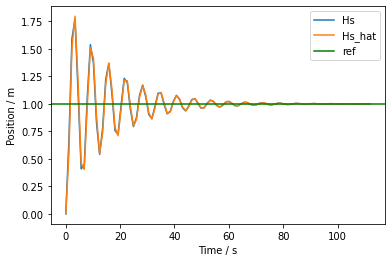

In [6]:
from matplotlib import pyplot as p
from scipy.signal import lti, step
import numpy as np
import libs.z3model as z3model

# model extraction
v_r = new_checker.amp
z = new_checker.zeta
omg = new_checker.omega_n
v_Kd = 2 * z * omg
v_Kp = omg * omg

# Original Transfer function
Hs_num = [v_Kd, v_Kp]
Hs_den = [1, v_Kd, v_Kp]
Hs = lti(Hs_num, Hs_den)
t, s = step(Hs)


# Approx Transfer function
Hs_num2 = [v_Kp]
Hs_den2 = [1, v_Kd, v_Kp]
Hs2 = lti(Hs_num2, Hs_den2)
t2, s2 = step(Hs2)


# plot
p.plot(t, s, label='Hs')
p.plot(t2, s2, label='Hs_hat')
p.axhline(y=1, color='g', label='ref')
p.xlabel('Time / s')
p.ylabel('Position / m')
p.legend()
p.show()